In [1]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
token = 'b6464d13b284902ed1d1a48d2aed6bd0474c7be45011741b0fb879614419659cb722e74a046af3d5caae0398aec9bdac8843068ecbee91aff466cf3e30f3bef5'
try:
    IBMQ.load_account()
except:
    qk.IBMQ.save_account(token=token)
    qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")


ibmqfactory.load_account:WARNING:2022-06-07 00:05:00,890: Credentials are already in use. The existing account in the session will be replaced.


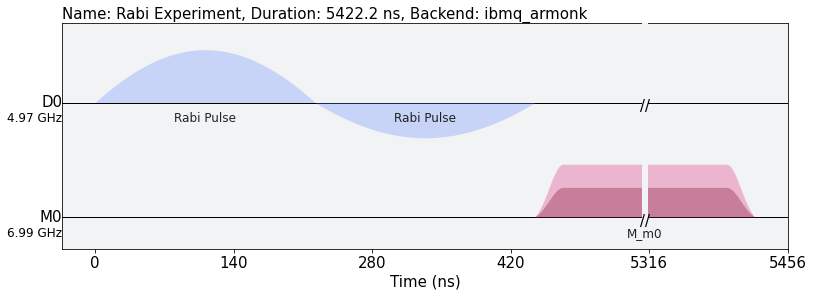

In [12]:
drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_1:
    pulse.play(pulse.Gaussian(duration=1000,amp=6*drive_amp,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
temp=Su22.Probe_Pulse(pulse_1,drive_amp,10)
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_2:
    pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
    pulse.call(temp[4],pulse.drive_channel(0))
pulse_2.draw(backend=backend)

In [14]:
hel = np.array([0,1,2,3,4,5,6])
hel = hel*drive_amp
print(hel)

[ParameterExpression(0) ParameterExpression(drive_amp)
 ParameterExpression(2*drive_amp) ParameterExpression(3*drive_amp)
 ParameterExpression(4*drive_amp) ParameterExpression(5*drive_amp)
 ParameterExpression(6*drive_amp)]


In [32]:
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as pulse_1:
    print(pulse.seconds_to_samples(2/9.00001*10**-9))

0


In [296]:
class Custom_Fgp:
    def __init__(self, inp,backend):
        self.input = np.array(inp)
        self.backend = backend
        #self.norm = self.input/np.sqrt((self.input**2).sum())
        self.norm = self.input/self.input.max()
        self.par = Parameter('drive_amp')
        with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(pulse.library.Constant(1, i*self.par),pulse.drive_channel(0)) for i in self.norm]
        self.cont = custom_Pulse

    def Create_Pulse(inp):
        inp = np.array(inp)
        #norm_inp = inp/np.sqrt((inp**2).sum())
        with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as custom_Pulse:
            [pulse.play(inp, pulse.drive_channel(0))]
        return custom_Pulse
    
    def draw(self):
        return Create_Pulse(self.input).draw(backend=self.backend)
    
    def baseline_remove(values):
        return np.array(values) - np.mean(values)

    def rabi_test(self,num_rabi_points):
        drive_amp_min = -1
        drive_amp_max = 1
        drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

        rabi_schedules = [self.cont.assign_parameters({self.par: a}, inplace=False) for a in drive_amps]
        num_shots_per_point = 1024
        job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)
        job_monitor(job)
        rabi_results = job.result(timeout=120)
        rabi_values = []
        for i in range(num_rabi_points):
            # Get the results for `qubit` from the ith experiment
            rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

        rabi_values = np.real(baseline_remove(rabi_values))

        return drive_amps,rabi_values

        

[18  2  5  3 19  9 16  7 10 10  9 14  7  6 14 14  5 14 17 11  5 15 11 16
 11 10  0 13  6 17  3 12  0 13  1 16  3  3  8 14 13 12 16 12  2 19  7  5
  3  9 19  5 17  1  6  6 12 18 18  9 18  3 14 12 17 10 10 19 17  1  2  9
 19  1  8 15 10  4 13 15  1  8 11  2 18 11  4  3 16 14  4 12 10 12  6  3
  8  7 18  1  7  2 11 11 17 15 10 14 10 19 10  6 13 13 14 19 17 10 15 15
 15  4  1 14 15  4  1 11  5 12 13 13 13 16  6 18 14 15 11  9  2  4 10  9
 16  3  2 14  5 12 16 11 13 18 10  1 15  4 19  0  5  4  0 12  5 15  4  7
  7  4 19  3  7 11 19  2  8 17  0 17 19 19  7 12 17  2 11 11 19  2 15  8
 13  0 19  6 10 13  5  9]
[0.94736842 0.10526316 0.26315789 0.15789474 1.         0.47368421
 0.84210526 0.36842105 0.52631579 0.52631579 0.47368421 0.73684211
 0.36842105 0.31578947 0.73684211 0.73684211 0.26315789 0.73684211
 0.89473684 0.57894737 0.26315789 0.78947368 0.57894737 0.84210526
 0.57894737 0.52631579 0.         0.68421053 0.31578947 0.89473684
 0.15789474 0.63157895 0.         0.68421053 0.05263158

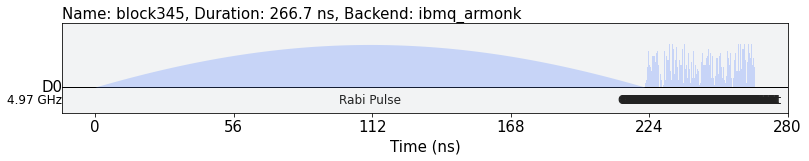

In [307]:
test= np.random.randint(20,size=200)
signal = Custom_Fgp(test,backend)
temp = signal.cont.assign_parameters({signal.par: 1})
with pulse.build(backend=backend) as pulse_2:
    pulse.play(pulse.Gaussian(duration=1000,amp=1,sigma=1000, name='Rabi Pulse'), pulse.drive_channel(0))
    pulse.call(temp,pulse.drive_channel(0))
print(signal.input)
print(signal.norm)
pulse_2.draw(backend=backend)

[1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 0]
[1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]


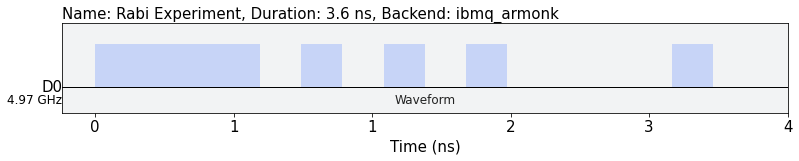

In [287]:
test2 =np.random.randint(20,size=200)
print(signal.input)
print(signal.norm)
Custom_Fgp.Create_Pulse(signal.norm).draw(backend=backend)

In [302]:
print(Su22.get_closest_multiple_of_16(10))

16
